In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import torch

MODEL = "roberta-large"
#MODEL = "cardiffnlp/twitter-roberta-base-sentiment"

# ✅ 关键参数：避免访问不存在的 additional_chat_templates 文件夹
tokenizer = AutoTokenizer.from_pretrained(MODEL, trust_remote_code=True, revision="main")
model = AutoModelForSequenceClassification.from_pretrained(MODEL, trust_remote_code=True, revision="main")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
def same_seeds(seed=42):
    import random, numpy as np, torch
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


In [25]:
path = 'train.csv'
import pandas as pd
df = pd.read_csv(path)[['text','sentiment','selected_text']]
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df = df.dropna().reset_index(drop=True)
#df = df[df['sentiment'] != 'neutral'].reset_index(drop=True)


# ... 上面的代码保持不变 ...
df = df.dropna().reset_index(drop=True)  # 这是截图中的第 5 行

# ================= 插入检查代码开始 =================
#print("正在检查数据多义性风险...")
count = 0
for idx, row in df.iterrows():
    text = str(row['text'])
    selected = str(row['selected_text'])
    
    # 查找选中文本在原句中的第一次和最后一次出现位置
    first_idx = text.find(selected)
    last_idx = text.rfind(selected)
    
    # 如果位置不一致，说明该词出现了多次，存在标记歧义风险
    if first_idx != last_idx and first_idx != -1:
        count += 1

#print(f"共有 {count} 条数据存在多义性风险")
# ================= 插入检查代码结束 =================

train_df = df.sample(frac=0.8, random_state=42) # 这是截图中的第 6 行
# ... 下面的代码保持不变 ...

# 检查有多少数据 find 返回了 -1
not_found_count = 0
for idx, row in df.iterrows():
    text = str(row['text'])
    selected = str(row['selected_text'])
    if text.find(selected) == -1:
        not_found_count += 1
#print(f"共有 {not_found_count} 条数据完全匹配不到 selected_text")


train_df = df.sample(frac=0.8, random_state=42)
val_df = df.drop(train_df.index)
train_text = train_df['text'].tolist()
train_sentiment = train_df['sentiment'].tolist()
train_selected_text = train_df['selected_text'].tolist()
val_text = val_df['text'].tolist()
val_sentiment = val_df['sentiment'].tolist()
val_selected_text = val_df['selected_text'].tolist()
print(f"Text: {train_text[7]}")
print(f"Sentiment: {train_sentiment[7]}")
print(f"Selected_Text: {train_selected_text[7]}")

Text:  I`m game, too bad your leaving HI!
Sentiment: negative
Selected_Text: bad


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import torch.nn as nn
import os
import pandas as pd

class LLMDataset(Dataset):
    def __init__(self, text, sentiment, selected_text = None, tokenizer = None, model = 'train', max_len=128):
      self.tokenizer = tokenizer
      self.model = model
      self.text = text
      self.sentiment = sentiment
      self.max_len = max_len # 保存 max_len
      if self.model in ['train','val']:
        self.selected_text = selected_text

    def __getitem__(self, idx):
      # 因为我们 .dropna() 了，所以这里 str() 只是额外的保险
      text = str(self.text[idx])
      sentiment = str(self.sentiment[idx])

      # 关键修复：只调用一次 tokenizer，同时请求 offset
      # truncation=True 会自动截断所有内容，包括 offset_mapping
      xencoded = self.tokenizer(
                                  sentiment,
                                  text,
                                  truncation=True,
                                  padding='max_length',
                                  max_length=self.max_len,
                                  return_tensors='pt',
                                  return_offsets_mapping=True
                               )

      # 分离模型输入和 offset 列表
      encoded = {key: val.squeeze(0) for key, val in xencoded.items() if key != 'offset_mapping'}
      offsets = xencoded['offset_mapping'].squeeze(0).tolist()

      if self.model in ['train','val']:
        selected_text_str = str(self.selected_text[idx])

        start_char = text.find(selected_text_str)
        end_char = start_char + len(selected_text_str)

        # 设置安全的默认值 (4, 4)，即 text 的第一个 token
        # 这会处理所有 "找不到" (start_char == -1) 的情况（比如拼写错误的脏数据）
        start = 4
        end = 4

        if start_char != -1: # 只有在 找得到 的情况下才去搜索
            start_found = False
            for i, (start_offset, end_offset) in enumerate(offsets):
              if i <= 3: # 跳过 [CLS], sentiment, [SEP], [SEP]
                continue
              if start_offset == 0 and end_offset == 0: # 跳过 padding
                continue

              if not start_found and start_offset <= start_char < end_offset:
                start = i
                start_found = True

              if start_found and start_offset < end_char <= end_offset:
                end = i
                break

            if start_found and end < start: # 如果 end 没找到 (被截断了)
                end = start

        # 返回正确的 tensor 格式
        return encoded, torch.tensor([start, end])
      else:
        return encoded

    def __len__(self):
      return len(self.text)

In [5]:
class TweetExtractionModel(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        from transformers import AutoModel
        self.roberta = AutoModel.from_pretrained(model_name)
        hidden = self.roberta.config.hidden_size
        self.dropout = nn.Dropout(0.1)
        self.start_fc = nn.Linear(hidden, 1)
        self.end_fc = nn.Linear(hidden, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden = outputs.last_hidden_state    # [batch, seq_len, hidden]
        last_hidden = self.dropout(last_hidden)
        start_logits = self.start_fc(last_hidden).squeeze(-1)
        end_logits   = self.end_fc(last_hidden).squeeze(-1)
        return start_logits, end_logits


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class ExactExpectedJaccardLoss(nn.Module):
    def __init__(self):
        super(ExactExpectedJaccardLoss, self).__init__()
    def compute_jaccard_matrix(self,true_start, true_end, seq_len):
        B = true_start.shape[0]
        idx = torch.arange(seq_len, device=true_start.device)
        i_grid, j_grid = torch.meshgrid(idx, idx, indexing='ij')   # [L,L], [L,L]
        i_grid = i_grid.unsqueeze(0).expand(B, -1, -1)
        j_grid = j_grid.unsqueeze(0).expand(B, -1, -1)
        ts = true_start.view(B,1,1)      # [B,1,1]
        te = true_end.view(B,1,1)        # [B,1,1]
        inter_l = torch.maximum(i_grid, ts)
        inter_r = torch.minimum(j_grid, te)
        inter_len = (inter_r - inter_l + 1).clamp(min=0)
        pred_len = (j_grid - i_grid + 1).clamp(min=0)
        true_len = (te - ts + 1).clamp(min=0)
        union_len = pred_len + true_len - inter_len
        jacc = (inter_len + 1e-6) / (union_len + 1e-6)
        mask = (i_grid <= j_grid).float()
        jacc = jacc * mask
        return jacc

    def forward(self, start_logits, end_logits, true_start, true_end):
        B,L = start_logits.shape
        p_start = F.softmax(start_logits, dim=1) 
        p_end   = F.softmax(end_logits, dim=1)
        probs = torch.einsum("bi,bj->bij", p_start, p_end)  # [B,L,L]
        triu_mask = torch.triu(torch.ones(L, L, device=probs.device))
        probs = probs * triu_mask.unsqueeze(0)
        total = probs.sum(dim=(1,2), keepdim=True)
        probs = probs / (total + 1e-8)
        jac_matrix = self.compute_jaccard_matrix(true_start,true_end,L)
        loss = (probs * jac_matrix).sum(dim=(1,2))
        loss = 1 - loss.mean()
        return loss

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LabelSmoothingLoss(nn.Module):
    """
    带标签平滑的 CrossEntropyLoss
    """
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        # pred: [Batch, Classes] (Logits)
        # target: [Batch] (Indices)
        
        # 1. 获得类别总数 (对于你的任务，通常是 max_len，即 128)
        n_classes = pred.size(1)
        
        # 2. 把 Logits 变成 Log Probability
        log_preds = F.log_softmax(pred, dim=-1)
        
        # 3. 计算 Standard Cross Entropy (Hard Label 部分)
        # nll_loss 只是 -log(p_correct)
        loss = -log_preds.gather(dim=-1, index=target.unsqueeze(-1))
        loss = loss.squeeze(-1)
        
        # 4. 计算 Smoothing 部分 (Soft Label 部分)
        # 我们希望模型对所有类别的预测概率之和有一定的惩罚
        smooth_loss = -log_preds.mean(dim=-1)
        
        # 5. 加权组合
        # (1 - epsilon) * Hard_Loss + epsilon * Soft_Loss
        final_loss = (1.0 - self.smoothing) * loss + self.smoothing * smooth_loss
        
        return final_loss.mean()

# --- 使用方法 ---
# 替换原本的 ce_criterion
# classes 数值不重要，因为上面的代码是动态计算的，但为了安全你可以传 max_len
ce_criterion = LabelSmoothingLoss(smoothing=0.1)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SpatialLabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super(SpatialLabelSmoothingLoss, self).__init__()
        # smoothing 是总共分出去的概率 (比如 0.1)
        # 我们把这 0.1 平均分给左边和右边，各得 0.05
        self.smoothing = smoothing
    
    def forward(self, pred, target):
        # pred: [Batch, Classes] (Logits)
        # target: [Batch] (Indices)
        
        # 1. 准备目标分布矩阵 (Batch, Seq_Len)
        n_classes = pred.size(1)
        batch_size = pred.size(0)
        
        # 初始化为全 0
        target_dist = torch.zeros_like(pred)
        
        # 2. 构建平滑分布
        # 主要概率 (1 - 0.1 = 0.9) 给正确位置
        confidence = 1.0 - self.smoothing
        # 左右各分一半 (0.05)
        side_prob = self.smoothing / 2.0
        
        # 填充正确位置
        target_dist.scatter_(1, target.unsqueeze(1), confidence)
        
        # 填充左边位置 (注意边界检查: index > 0)
        left_target = (target - 1).clamp(min=0)
        # 只有当 target > 0 时才加到左边，否则加回给正确位置以保持总和为1
        # 这里简化处理：直接尝试 scatter，如果在边界上就忽略或叠加
        # 为了严谨，我们用 mask 处理边界
        left_mask = (target > 0)
        if left_mask.any():
            # 只有非边界的样本才分散给左边
            target_dist.scatter_(1, left_target.unsqueeze(1) * left_mask.unsqueeze(1), side_prob)
            
        # 填充右边位置 (注意边界检查: index < max_len - 1)
        right_target = (target + 1).clamp(max=n_classes - 1)
        right_mask = (target < n_classes - 1)
        if right_mask.any():
            target_dist.scatter_(1, right_target.unsqueeze(1) * right_mask.unsqueeze(1), side_prob)

        # 归一化 (防止边界上的概率之和不为1，虽然 LogSoftmax 不强制和为1，但 KLDiv 需要)
        # 简单的 trick: 没分出去的概率加回给 target (比如 index=0 时，左边的 0.05 加回给 0)
        current_sum = target_dist.sum(dim=1, keepdim=True)
        target_dist = target_dist / current_sum

        # 3. 计算 KL Divergence Loss
        # KLDivLoss = target * (log(target) - log(pred))
        # PyTorch 的 KLDivLoss 接收 LogSoftmax 输入
        log_preds = F.log_softmax(pred, dim=-1)
        
        # reduction='batchmean' 是数学上正确的平均
        loss = F.kl_div(log_preds, target_dist, reduction='batchmean')
        
        return loss

# --- 使用 ---
# ls_criterion = SpatialLabelSmoothingLoss(smoothing=0.1)

In [9]:
from tqdm import tqdm
import math
import numpy as np
model_name = "roberta-large"
#model_name = "cardiffnlp/twitter-roberta-base-sentiment"
config = { 'seed':42,
          'batch_size':32,
           'n_epochs':400,
           'learning_rate':2e-5,
           'model_path':'./models/model.ckpt',
           'early_stop':3,
           'num_workers':4,
           'weight_decay':1e-5,
            'lambda':0.5
         }
device = 'cuda' if torch.cuda.is_available() else 'cpu'
max_len = 128 # 确保这个值和你的 tokenizer/config 一致
train_dataset = LLMDataset(train_text, train_sentiment, train_selected_text, tokenizer, 'train', max_len=max_len)
val_dataset = LLMDataset(val_text, val_sentiment, val_selected_text, tokenizer, 'val', max_len=max_len)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=config['num_workers'])
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=config['num_workers'])
model = TweetExtractionModel(model_name)
model.to(device)
same_seeds(config['seed'])

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
import math
import numpy as np
import torch
import os
from transformers import get_linear_schedule_with_warmup

def jaccard(str1, str2):
    """
    Calculates the Jaccard similarity score between two strings.
    """
    a = set(str(str1).lower().split())
    b = set(str(str2).lower().split())
    if not a and not b:
        return 1.0  # Both empty strings are a perfect match
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c)) if (len(a) + len(b) - len(c)) != 0 else 0.0

# --- 评估函数 (已修复索引 Bug) ---
def evaluate_jaccard(model, val_loader, tokenizer, val_dataset, device, batch_size):
    """
    Evaluates the model's performance on the validation set using the Jaccard score.
    Returns both overall and sentiment-specific Jaccard averages.
    """
    model.eval()
    
    # --- 存储各情感类别的jaccard总和与计数 ---
    jaccard_sum = {"positive": 0.0, "negative": 0.0, "neutral": 0.0}
    jaccard_count = {"positive": 0, "negative": 0, "neutral": 0}
    total_jaccard = 0.0
    total_count = 0
    with torch.no_grad():
        for batch_idx, (encoded, y) in tqdm(enumerate(val_loader), total=len(val_loader), desc="Eval Jaccard"):
            encoded = {k: v.to(device) for k, v in encoded.items()}
            start_logits, end_logits = model(**encoded)
            start_pred = torch.argmax(start_logits, dim=1)
            end_pred = torch.argmax(end_logits, dim=1)
            for i in range(len(start_pred)):
                global_idx = batch_idx * batch_size + i
                if global_idx >= len(val_dataset.selected_text):
                    continue
                s = start_pred[i].item()
                e = end_pred[i].item()
                if e < s:
                    e = s
                input_ids_tensor = encoded["input_ids"][i]
                pred_tokens = input_ids_tensor[s : e + 1]
                pred_text = tokenizer.decode(pred_tokens)
                true_text = val_dataset.selected_text[global_idx]
                # 计算当前样本的 jaccard
                score = jaccard(pred_text, true_text)
                total_jaccard += score
                total_count += 1
                # --- 按情感类别累积 ---
                sentiment = val_dataset.sentiment[global_idx].lower()
                if sentiment in jaccard_sum:
                    jaccard_sum[sentiment] += score
                    jaccard_count[sentiment] += 1
    # --- 平均化 ---
    overall = total_jaccard / total_count if total_count > 0 else 0.0
    sentiment_jaccard = {
        s: (jaccard_sum[s] / jaccard_count[s] if jaccard_count[s] > 0 else 0.0)
        for s in jaccard_sum
    }
    sentiment_jaccard["overall"] = overall
    return sentiment_jaccard
    
from tqdm import tqdm
# --- 训练函数 ---
def train(train_loader, val_loader, model, device, config, val_dataset, tokenizer):
    jac_criterion = ExactExpectedJaccardLoss() 
    ce_criterion = nn.CrossEntropyLoss()
    criterion = SpatialLabelSmoothingLoss(smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=config['learning_rate'],weight_decay=config['weight_decay'])
    total_steps = len(train_loader) * config['n_epochs']
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=total_steps)
    best_jaccard = 0.0
    save_path = config['model_path']
    early_stop = 0
    train_loss_list = []
    val_loss_list = []
    diff_list = []
    jac_pos = []
    jac_neg = []
    jac_neu = []
    jac_ova = []
    if not os.path.isdir('./models'):
        os.mkdir('./models')
    for epoch in range(config['n_epochs']):
        model.train()  # ✅ 每轮开始前切回训练模式
        count = 0.0
        train_loss = 0.0
        # --- Training ---
        for i, data in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch} Train"):
            optimizer.zero_grad()
            encoded, y = data
            encoded = {k: v.to(device) for k, v in encoded.items()}
            y = y.to(device)
            start_logits, end_logits = model(**encoded)
            #ce_loss = ce_criterion(start_logits, y[:, 0]) + ce_criterion(end_logits, y[:, 1])
            #jac_loss = jac_criterion(start_logits, end_logits, y[:, 0], y[:, 1])
            #loss = ce_loss + 0.5 * jac_loss # 0.5 是推荐系
            loss = criterion(start_logits, y[:, 0]) + criterion(end_logits, y[:, 1])
            #loss = ce_loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step() # ✅ 记得加回这一行
            # ... 后面的代码 ...
            train_loss += loss.item()
            count += 1
        train_loss_list.append(train_loss / count)
        print(f"Epoch:{epoch} | train loss: {train_loss / count:.4f}")
        # --- Validation ---
        model.eval()
        val_loss = 0.0
        count = 0.0
        diff = 0.0
        with torch.no_grad():
            for i, data in tqdm(enumerate(val_loader), total=len(val_loader), desc=f"Epoch {epoch} Val"):
                encoded, y = data
                encoded = {k: v.to(device) for k, v in encoded.items()}
                y = y.to(device)
                start_logits, end_logits = model(**encoded)
                #ce_loss = ce_criterion(start_logits, y[:, 0]) + ce_criterion(end_logits, y[:, 1])
                #jac_loss = jac_criterion(start_logits, end_logits, y[:, 0], y[:, 1])
                #loss = ce_loss + 0.5 * jac_loss # 0.5 是推荐系数
                #loss = ce_loss
                loss = criterion(start_logits, y[:, 0]) + criterion(end_logits, y[:, 1])
                # 1. 把分数变成位置索引 (Tensor shape: [Batch])
                pred_start_idx = torch.argmax(start_logits, dim=1) 
                pred_end_idx = torch.argmax(end_logits, dim=1)
                # 2. 计算长度 (Tensor shape: [Batch
                # 这里的 +1 是因为长度包含首尾 (例如 start=2, end=2, len 应该是 1)
                pred_lengths = pred_end_idx - pred_start_idx + 1
                label_lengths = y[:,1] - y[:,0] + 1
                diff += (label_lengths - pred_lengths).float().mean().item()
                val_loss += loss.item()
                count += 1
        val_loss_list.append(val_loss / count)
        val_jaccard_dict = evaluate_jaccard(model, val_loader, tokenizer, val_dataset, device, config['batch_size'])
        overall_jac = val_jaccard_dict["overall"]
        diff_list.append(diff / count)
        jac_pos.append(val_jaccard_dict['positive'])
        jac_neg.append(val_jaccard_dict['negative'])
        jac_neu.append(val_jaccard_dict['neutral'])
        jac_ova.append(val_jaccard_dict['overall'])
        print(
              f"Epoch:{epoch} | val loss: {val_loss / count:.4f} | "
              f"Overall Jaccard: {overall_jac:.4f} | "
              f"Pos: {val_jaccard_dict['positive']:.4f} | "
              f"Neu: {val_jaccard_dict['neutral']:.4f} | "
              f"Neg: {val_jaccard_dict['negative']:.4f} |"
                f"Diff: {diff / count:.4f}"
              )
        # --- Early stopping logic ---
        if overall_jac > best_jaccard:
            best_jaccard = overall_jac
            early_stop = 0
            torch.save(model.state_dict(), save_path)
            print(f"✅ Model saved at epoch {epoch}, Jaccard improved to {overall_jac:.4f}")
        else:
            early_stop += 1
            if early_stop >= config["early_stop"]:
                print(f"⏹ Early stop at epoch {epoch}")
                break
        model.train()  # ✅ 验证完后回到训练模式
    return train_loss_list, val_loss_list, diff_list, jac_pos, jac_neg, jac_neu, jac_ova# ✅ return 放在循环外现在没有问题了吧


In [128]:
train_loss = []
val_loss = []
diff = []
train_loss,val_loss,diff,jac_pos,jac_neg,jac_neu,jac_ova = train(train_loader,val_loader,model,device,config,val_dataset,tokenizer)    

Epoch 0 Train: 100%|██████████| 687/687 [03:19<00:00,  3.44it/s]

Epoch:0 | train loss: 2.1973



Eval Jaccard: 100%|██████████| 172/172 [00:14<00:00, 11.93it/s]


Epoch:0 | val loss: 1.4446 | Overall Jaccard: 0.6898 | Pos: 0.4978 | Neu: 0.9671 | Neg: 0.5060 |Diff: 0.5243
✅ Model saved at epoch 0, Jaccard improved to 0.6898


Epoch 1 Train: 100%|██████████| 687/687 [03:20<00:00,  3.42it/s]

Epoch:1 | train loss: 1.4006



Eval Jaccard: 100%|██████████| 172/172 [00:14<00:00, 11.84it/s]


Epoch:1 | val loss: 1.3989 | Overall Jaccard: 0.6928 | Pos: 0.5089 | Neu: 0.9652 | Neg: 0.5072 |Diff: -0.0454
✅ Model saved at epoch 1, Jaccard improved to 0.6928


Epoch 2 Train: 100%|██████████| 687/687 [03:18<00:00,  3.46it/s]

Epoch:2 | train loss: 1.1901



Eval Jaccard: 100%|██████████| 172/172 [00:14<00:00, 11.93it/s]


Epoch:2 | val loss: 1.4351 | Overall Jaccard: 0.7051 | Pos: 0.5252 | Neu: 0.9728 | Neg: 0.5218 |Diff: 0.4813
✅ Model saved at epoch 2, Jaccard improved to 0.7051


Epoch 3 Train: 100%|██████████| 687/687 [03:18<00:00,  3.46it/s]

Epoch:3 | train loss: 1.0056



Eval Jaccard: 100%|██████████| 172/172 [00:14<00:00, 12.02it/s]


Epoch:3 | val loss: 1.6416 | Overall Jaccard: 0.7084 | Pos: 0.5292 | Neu: 0.9699 | Neg: 0.5332 |Diff: 0.4710
✅ Model saved at epoch 3, Jaccard improved to 0.7084


Epoch 4 Train: 100%|██████████| 687/687 [03:17<00:00,  3.47it/s]

Epoch:4 | train loss: 0.8565



Eval Jaccard: 100%|██████████| 172/172 [00:14<00:00, 12.04it/s]

Epoch:4 | val loss: 1.7787 | Overall Jaccard: 0.7050 | Pos: 0.5275 | Neu: 0.9629 | Neg: 0.5329 |Diff: 0.6809



Epoch 5 Train: 100%|██████████| 687/687 [03:18<00:00,  3.46it/s]

Epoch:5 | train loss: 0.7043



Eval Jaccard: 100%|██████████| 172/172 [00:14<00:00, 11.97it/s]

Epoch:5 | val loss: 1.8639 | Overall Jaccard: 0.7044 | Pos: 0.5255 | Neu: 0.9706 | Neg: 0.5219 |Diff: 0.0477



Epoch 6 Train: 100%|██████████| 687/687 [03:18<00:00,  3.45it/s]

Epoch:6 | train loss: 0.5664



Eval Jaccard: 100%|██████████| 172/172 [00:14<00:00, 11.99it/s]

Epoch:6 | val loss: 2.2590 | Overall Jaccard: 0.6903 | Pos: 0.4929 | Neu: 0.9705 | Neg: 0.5082 |Diff: -0.7772
⏹ Early stop at epoch 6


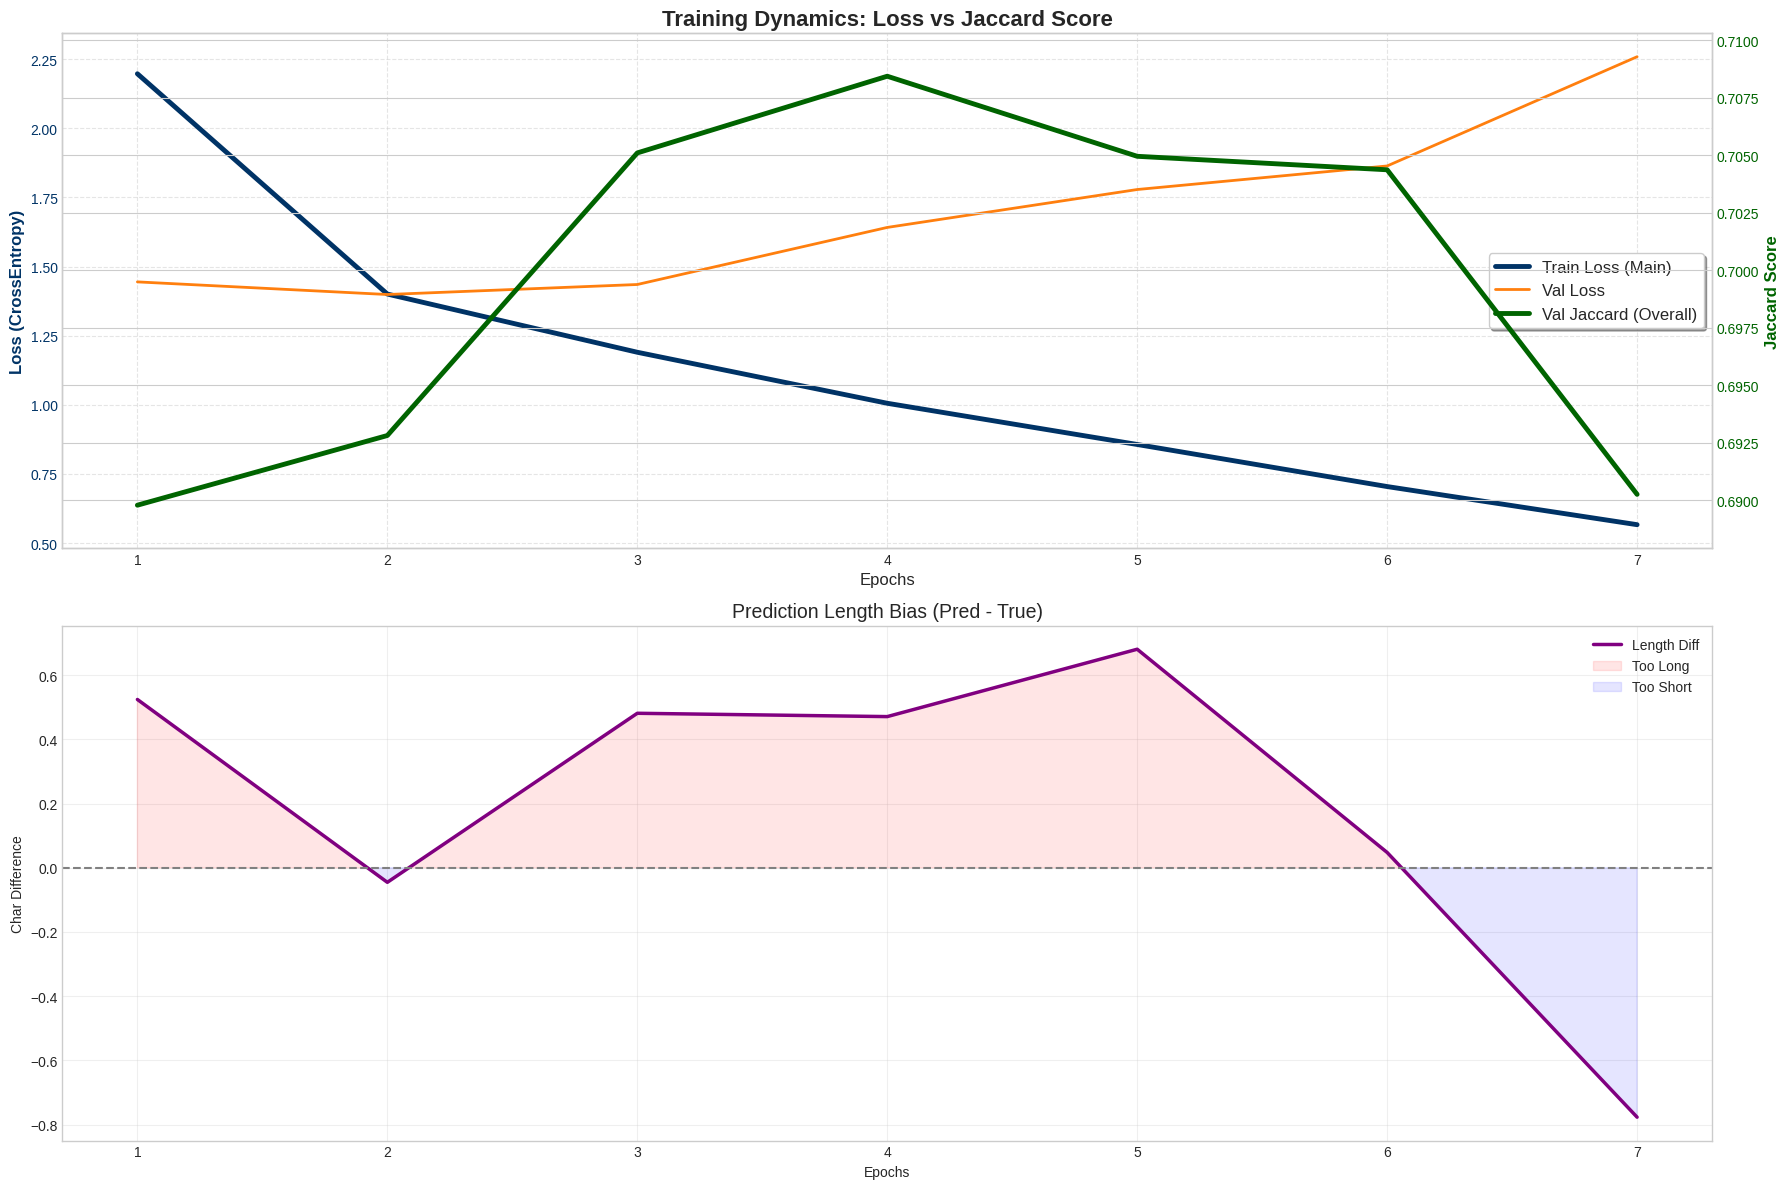

In [129]:
import matplotlib.pyplot as plt
import numpy as np

# 1. 准备 X 轴数据
epochs = range(1, len(train_loss) + 1)

# 设置风格
plt.style.use('seaborn-v0_8-whitegrid') 

# 2. 设置画布大小 (改为 2 行 1 列，上下排列，图表更大更清晰)
fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(18, 12)) 

# ==========================================
# 图 1：【核心图】Loss 与 Jaccard 趋势对比
# ==========================================

# --- 左轴：画 Loss ---
# 重点 1: Train Loss 用深色、加粗 (linewidth=3.5)
color_t_loss = '#003366' # 深海军蓝
color_v_loss = '#ff7f0e' # 标准橙色

line1, = ax1.plot(epochs, train_loss, color=color_t_loss, linewidth=3.5, label='Train Loss (Main)')
line2, = ax1.plot(epochs, val_loss, color=color_v_loss, linewidth=2, linestyle='-', label='Val Loss')

ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Loss (CrossEntropy)', fontsize=12, color=color_t_loss, fontweight='bold')
ax1.tick_params(axis='y', labelcolor=color_t_loss)

# --- 右轴：画 Jaccard ---
ax2 = ax1.twinx() 
# 重点 2: Jaccard 用深色、加粗 (linewidth=3.5)
color_jac = '#006400' # 深绿色
line3, = ax2.plot(epochs, jac_ova, color=color_jac, linewidth=3.5, linestyle='-', label='Val Jaccard (Overall)')

ax2.set_ylabel('Jaccard Score', fontsize=12, color=color_jac, fontweight='bold')
ax2.tick_params(axis='y', labelcolor=color_jac)

# --- 自动聚焦 Y 轴 (让 Jaccard 变化更明显) ---
if len(jac_ova) > 0:
    min_jac = min(jac_ova)
    max_jac = max(jac_ova)
    # 缩小边距，让曲线铺满画面，波动看起来更剧烈
    margin = (max_jac - min_jac) * 0.1 
    if margin == 0: margin = 0.05
    ax2.set_ylim(min_jac - margin, max_jac + margin)

# --- 合并图例 ---
lines = [line1, line2, line3]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='center right', fontsize=12, frameon=True, shadow=True, facecolor='white')

ax1.set_title('Training Dynamics: Loss vs Jaccard Score', fontsize=16, fontweight='bold')
ax1.grid(True, linestyle='--', alpha=0.5)

# ==========================================
# 图 2：Diff 长度偏差 (保留的 Diff 图)
# ==========================================
# 此时 ax3 就是第二张图的对象

ax3.plot(epochs, diff, color='purple', linewidth=2.5, label='Length Diff')
ax3.axhline(0, color='gray', linestyle='--', linewidth=1.5)

ax3.set_title('Prediction Length Bias (Pred - True)', fontsize=14)
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Char Difference')

# 填充颜色，让偏差更直观
ax3.fill_between(epochs, diff, 0, where=(np.array(diff) > 0), interpolate=True, color='red', alpha=0.1, label='Too Long')
ax3.fill_between(epochs, diff, 0, where=(np.array(diff) < 0), interpolate=True, color='blue', alpha=0.1, label='Too Short')

ax3.legend(loc='upper right')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

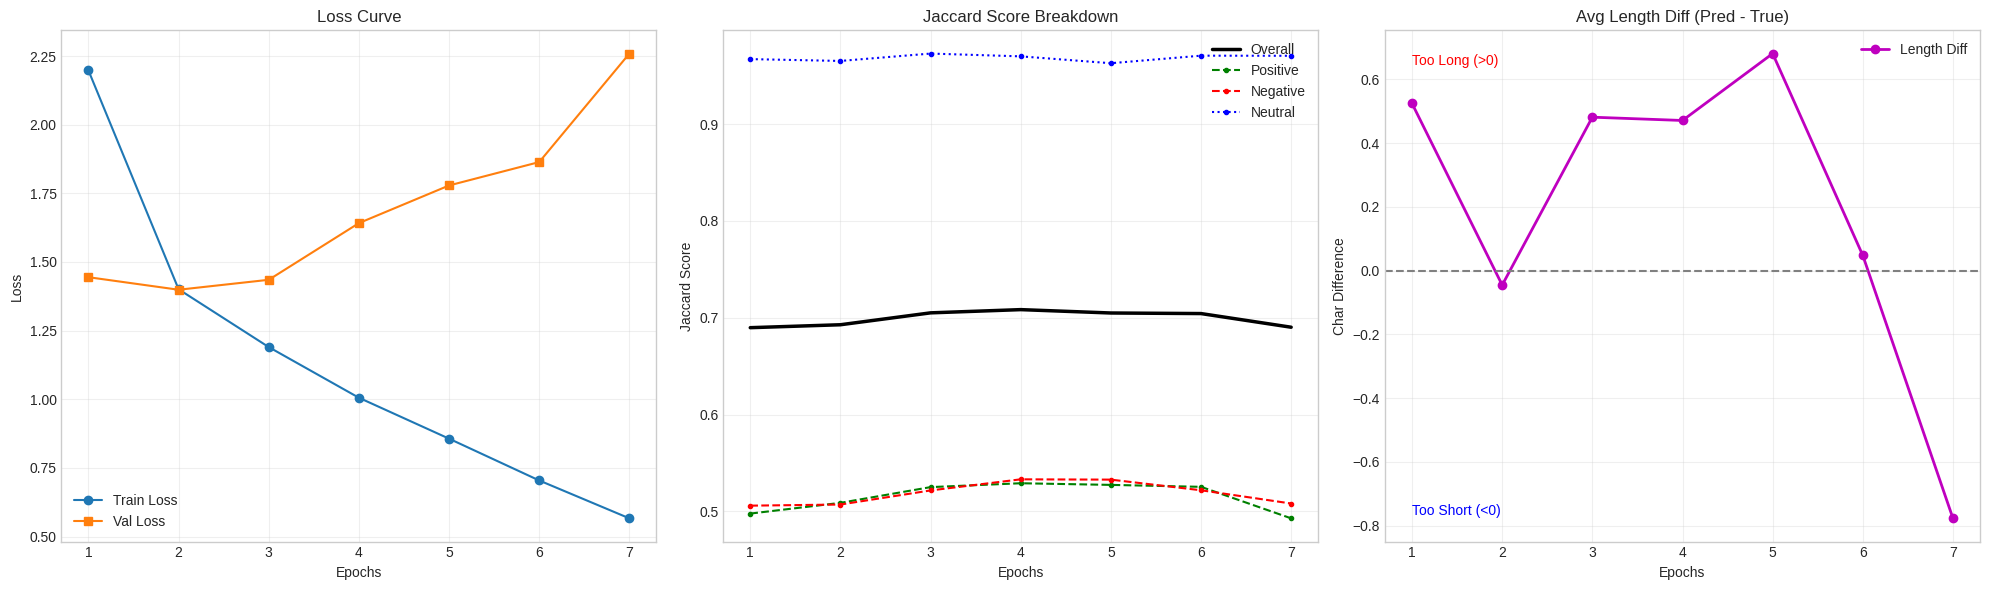

In [130]:
import matplotlib.pyplot as plt

# 1. 准备 X 轴数据 (Epochs)
epochs = range(1, len(train_loss) + 1)

# 2. 设置画布大小
plt.figure(figsize=(20, 6))

# ==========================================
# 图 1：Train Loss vs Val Loss
# ==========================================
plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss, 'o-', label='Train Loss', color='tab:blue')
plt.plot(epochs, val_loss, 's-', label='Val Loss', color='tab:orange')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# ==========================================
# 图 2：Jaccard 曲线 (Overall + 3 Sentiments)
# ==========================================
plt.subplot(1, 3, 2)
# Overall: 用黑色粗线，显眼
plt.plot(epochs, jac_ova, 'k-', linewidth=2.5, label='Overall')
# 各个情感: 用彩色虚线
plt.plot(epochs, jac_pos, 'g--', marker='.', label='Positive')
plt.plot(epochs, jac_neg, 'r--', marker='.', label='Negative')
plt.plot(epochs, jac_neu, 'b:', marker='.', label='Neutral')

plt.title('Jaccard Score Breakdown')
plt.xlabel('Epochs')
plt.ylabel('Jaccard Score')
plt.legend()
plt.grid(True, alpha=0.3)

# ==========================================
# 图 3：Diff (长度偏差诊断)
# ==========================================
plt.subplot(1, 3, 3)
plt.plot(epochs, diff, 'm-o', linewidth=2, label='Length Diff')
# 画一条 0 刻度线作为完美基准
plt.axhline(0, color='gray', linestyle='--', linewidth=1.5)

plt.title('Avg Length Diff (Pred - True)')
plt.xlabel('Epochs')
plt.ylabel('Char Difference')

# 动态调整文字位置，防止遮挡曲线
y_max = max(diff) if diff else 0.5
y_min = min(diff) if diff else -0.5
plt.text(epochs[0], y_max, 'Too Long (>0)', color='red', fontsize=10, verticalalignment='top')
plt.text(epochs[0], y_min, 'Too Short (<0)', color='blue', fontsize=10, verticalalignment='bottom')

plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [131]:
from tqdm import tqdm

model.eval()
N = 3  # 只看前5条
shown = 0

with torch.no_grad():
    for i in tqdm(range(len(val_dataset)), desc="Sample predictions"):
        text = val_dataset.text[i]
        sentiment = val_dataset.sentiment[i]
        true_text = val_dataset.selected_text[i]

        # 🔹重新调用 tokenizer 获取 offset_mapping
        encoded = tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=max_len,
            return_offsets_mapping=True,
            return_tensors='pt'
        )

        # 取出模型输入部分
        encoded_to_model = {k: v.to(device) for k, v in encoded.items() if k in ('input_ids', 'attention_mask')}
        offsets = encoded["offset_mapping"][0].numpy()

        # 🔹模型预测
        start_logits, end_logits = model(**encoded_to_model)
        start_pred = torch.argmax(start_logits, dim=1).item()
        end_pred = torch.argmax(end_logits, dim=1).item()

        # 🔹确保 s <= e
        s, e = min(start_pred, end_pred), max(start_pred, end_pred)
        start_char, end_char = int(offsets[s][0]), int(offsets[e][1])
        pred_text = text[start_char:end_char]

        # 🔹打印结果
        print(f"\n🟩 Example {shown+1}")
        print(f"Sentiment: {sentiment}")
        print(f"Text: {text}")
        print(f"✅ Predicted: {pred_text}")
        print(f"🎯 True: {true_text}")

        shown += 1
        if shown >= N:
            break




Sample predictions:   0%|          | 14/5496 [00:00<03:06, 29.38it/s]


🟩 Example 1
Sentiment: neutral
Text: wee. done with advance audit paper
✅ Predicted: wee. done with advance audit paper
🎯 True: wee. done with advance audit paper

🟩 Example 2
Sentiment: negative
Text: I`m bummed that I didn`t get TEDx tickets
✅ Predicted: bummed
🎯 True: bummed

🟩 Example 3
Sentiment: neutral
Text: There`s starwars day? ) OMG Rocio!
✅ Predicted: OMG Rocio!
🎯 True: There`s starwars day? ) OMG Rocio!

🟩 Example 4
Sentiment: negative
Text: _zorz_peep count yourself lucky i was gonna say the OTHER word instead...and rsvp...sorry i cant come to ur birthday...day?
✅ Predicted: count yourself lucky
🎯 True: sorry

🟩 Example 5
Sentiment: neutral
Text: No more tickets for today.  Having dinner with Mimcy after work, then we head home. Then again, she might get a call
✅ Predicted: No more tickets for today.
🎯 True: No more tickets for today.  Having dinner with Mimcy after work, then we head home. Then again, she might get a call

🟩 Example 6
Sentiment: positive
Text:   I wish I

In [22]:
path = 'test.csv'
import pandas as pd
df = pd.read_csv(path)[['text','sentiment']]
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df = df.dropna().reset_index(drop=True)
test_text = df['text'].tolist()
test_sentiment = df['sentiment'].tolist()


In [17]:
def test_model(model, tokenizer, test_texts, test_sentiments, device, max_len=64, num_samples=10):
    """
    使用训练好的模型在测试/验证集上进行推理，并打印部分样本结果。
    参数:
        model: 训练好的 TweetExtractionModel
        tokenizer: 与模型对应的 tokenizer
        test_texts: 文本列表
        test_sentiments: 对应的情感列表
        device: 'cuda' 或 'cpu'
        max_len: tokenizer 最大长度
        num_samples: 打印的样本数量（默认10）
    """

    model.eval()
    preds, spans = [], []
    n = len(test_texts)

    with torch.no_grad():
        for i in tqdm(range(n), desc="Testing"):
            text = test_texts[i]
            sentiment = test_sentiments[i]

            # 重新调用 tokenizer 以获得 offset_mapping
            encoded = tokenizer(
                text,
                truncation=True,
                padding='max_length',
                max_length=max_len,
                return_offsets_mapping=True,
                return_tensors='pt'
            )

            offsets = encoded["offset_mapping"][0].numpy()
            encoded_to_model = {k: v.to(device) for k, v in encoded.items() if k in ("input_ids", "attention_mask")}

            # 模型预测
            start_logits, end_logits = model(**encoded_to_model)
            start_pred = torch.argmax(start_logits, dim=1).item()
            end_pred = torch.argmax(end_logits, dim=1).item()

            # 修正反序
            s, e = min(start_pred, end_pred), max(start_pred, end_pred)
            start_char, end_char = int(offsets[s][0]), int(offsets[e][1])
            pred_text = text[start_char:end_char]

            preds.append(pred_text)
            spans.append((s, e))

            # 打印部分样本
            if i < num_samples:
                print(f"\n🟩 Example {i+1}")
                print(f"Sentiment: {sentiment}")
                print(f"Text: {text}")
                print(f"✅ Predicted: {pred_text}")

    print(f"\n✅ Finished! Generated {len(preds)} predictions.")
    return preds, spans


In [19]:
import pandas as pd
import torch
from tqdm import tqdm

def generate_submission(model, tokenizer, test_texts, test_sentiments, device, max_len=64, save_path='test.csv'):
    """
    在测试集上生成预测结果并保存为 test.csv
    结果包含: text, sentiment, selected_text
    """
    model.eval()
    preds = []

    with torch.no_grad():
        for text, sentiment in tqdm(zip(test_texts, test_sentiments), total=len(test_texts), desc="Generating test.csv"):
            # 重新tokenize拿offset
            encoded = tokenizer(
                text,
                truncation=True,
                padding='max_length',
                max_length=max_len,
                return_offsets_mapping=True,
                return_tensors='pt'
            )
            offsets = encoded["offset_mapping"][0].numpy()
            encoded_to_model = {k: v.to(device) for k, v in encoded.items() if k in ("input_ids", "attention_mask")}

            # 模型预测
            start_logits, end_logits = model(**encoded_to_model)
            start_pred = torch.argmax(start_logits, dim=1).item()
            end_pred = torch.argmax(end_logits, dim=1).item()

            s, e = min(start_pred, end_pred), max(start_pred, end_pred)
            start_char, end_char = int(offsets[s][0]), int(offsets[e][1])
            pred_text = text[start_char:end_char].strip()

            preds.append(pred_text)

    df = pd.DataFrame({
        "text": test_texts,
        "sentiment": test_sentiments,
        "selected_text": preds
    })

    df.to_csv(save_path, index=False, encoding='utf-8-sig')
    print(f"✅ Saved {len(preds)} predictions to {save_path}")
    return df


In [20]:
model = TweetExtractionModel(model_name)
model.load_state_dict(torch.load('./models/model.ckpt', map_location=device))
model.to(device)

df_sub = generate_submission(model, tokenizer, test_text, test_sentiment, device, save_path='test.csv')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Generating test.csv: 100%|██████████| 3534/3534 [00:16<00:00, 213.19it/s]


✅ Saved 3534 predictions to test.csv
